In [1]:
import Pkg
Pkg.activate("../../Tasks2D")

using Revise, Plots
import LineWorlds
const L = LineWorlds
const Geo = L.Geometry

import GridWorlds
const GW = GridWorlds

using Gen
import GenPOMDPs

using GenSMCP3
# We need this to help with dualizing and undualizing values...
const DFD = GenSMCP3.GenTraceKernelDSL.DynamicForwardDiff

using VoxelRayTracers # For lineworld -> gridworld
using AStarSearch     # For gridworld path planning

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


In [2]:
(_segs, _bb, _center) = L.load_env_sparse("/Users/georgematheos/Developer/research/summer2023/tasks2d/data/environments/ambig.json")

(_segs = LineWorlds.Geometry.Segment[LineWorlds.Geometry.Segment([0.0, 0.0], [5.4, 0.0]), LineWorlds.Geometry.Segment([5.4, 0.0], [5.4, 12.0]), LineWorlds.Geometry.Segment([5.4, 12.0], [0.0, 12.0]), LineWorlds.Geometry.Segment([0.0, 12.0], [0.0, 0.0]), LineWorlds.Geometry.Segment([0.0, 0.0], [0.0, 2.0]), LineWorlds.Geometry.Segment([0.0, 2.0], [4.0, 2.0]), LineWorlds.Geometry.Segment([4.0, 2.0], [4.0, 3.0]), LineWorlds.Geometry.Segment([4.0, 3.0], [4.0, 2.0]), LineWorlds.Geometry.Segment([4.0, 2.0], [0.0, 2.0]), LineWorlds.Geometry.Segment([0.0, 2.0], [0.0, 6.0])  …  LineWorlds.Geometry.Segment([4.0, 6.0], [4.0, 7.0]), LineWorlds.Geometry.Segment([4.0, 7.0], [4.0, 6.0]), LineWorlds.Geometry.Segment([4.0, 6.0], [0.0, 6.0]), LineWorlds.Geometry.Segment([0.0, 6.0], [0.0, 10.0]), LineWorlds.Geometry.Segment([0.0, 10.0], [4.0, 10.0]), LineWorlds.Geometry.Segment([4.0, 10.0], [4.0, 8.0]), LineWorlds.Geometry.Segment([4.0, 8.0], [4.0, 10.0]), LineWorlds.Geometry.Segment([4.0, 10.0], [0.0, 10.

In [3]:
function line_to_grid(_segs, _bb, ϵ)
    (x1, y1), (x2, y2) = _bb
    edges = ((x1 - ϵ):ϵ:(x2 + ϵ), (y1 - ϵ):ϵ:(y2 + ϵ))

    grid = [false for _ in edges[1], _ in edges[2]]
    for seg in _segs
        if Geo.diff(seg) ≈ [0, 0]
            continue
        end
        ray = (position=seg.x, velocity=Geo.diff(seg))
        for hit in eachtraversal(ray, edges)
                                    # TODO: is this a hack or no?
            if hit.exit_time ≤ 1. #|| (hit.entry_time == 1.0 && (ray.velocity[1] > 0 || ray.velocity[2] > 0))
                grid[hit.voxelindex] = true
            end
        end
    end

    linecoords_to_gridcoords(x, y) = (
        Int(round((x - edges[1][1] + ϵ) / ϵ)),
        Int(round((y - edges[2][1] + ϵ) / ϵ))
    )
    gridcoords_to_linecoords(x, y) = (
        edges[1][x],
        edges[2][y]
    )

    return grid, edges, linecoords_to_gridcoords, gridcoords_to_linecoords
end

line_to_grid (generic function with 1 method)

In [4]:
ϵ = 0.25
(grid, edges, l_to_g, g_to_l) = line_to_grid(_segs, _bb, ϵ)
w = GridWorlds.boolmatrix_to_grid(grid, (length(edges[1]), length(edges[2])))

GridWorlds.FGridWorld(FunctionalCollections.PersistentVector{GridWorlds.GridCell}[[GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty  …  GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty], [GridWorlds.empty, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall  …  GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.empty], [GridWorlds.empty, GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall  …  GridWorlds.wall, GridWor

In [5]:
taxi_dist((x, y), (x2, y2)) = abs(x - x2) + abs(y - y2)
function find_action_using_grid(start_linecoords, goal_linecoords)
    actions = (:up, :down, :left, :right, :stay)
    initialpos = l_to_g(start_linecoords...)
    goalpos    = l_to_g(goal_linecoords...)

    results = astar(
        # state to neighbors
        pos -> unique(GW.newpos(w, pos, dir) for dir in actions),
        initialpos, # Initial world state
        goalpos; # Goal world state
        heuristic = ((pos, goal) -> taxi_dist(pos, goal)),
        isgoal = ((pos, goal) -> pos == goal),
        timeout = 10.
    )

    next_state = results.path[2]
    # println("next_state: ", g_to_l(next_state...))
    action = actions[findfirst(GW.newpos(w, initialpos, dir) == next_state for dir in actions)]

    return (action, results.path)
end

find_action_using_grid (generic function with 1 method)

In [200]:
PARAMS = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (;
        Δ = 0.25,
        σ = 0.02
    ),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.02,
            outlier      = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

In [201]:
mvuniform = L.ProductDistribution(uniform);
@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as list of line segments
    
    mins, maxs = PARAMS.bounding_box
    pos ~ mvuniform(mins, maxs)
    
    return pos
end
@load_generated_functions()

### Motion model ###
# The next position, under a 0-noise model, with no walls.
function det_next_pos(pos, a, Δ)
    (x, y) = DFD.value(pos)
    a == :up    ? [x, y + Δ] :
    a == :down  ? [x, y - Δ] : 
    a == :left  ? [x - Δ, y] :
    a == :right ? [x + Δ, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end
function handle_wall_intersection(prev, new, walls)
    move = L.Segment(DFD.value(prev), DFD.value(new))
    for wall in walls
        do_intersect, dist = L.Geometry.cast(move, wall)
        if do_intersect && dist ≤ L.Geometry.norm(move)
            return prev
        end
    end
    return new
end
@gen (static) function motion_model(prev_pos, action, PARAMS)
    np = det_next_pos(prev_pos, action, PARAMS.step.Δ)
    pos ~ broadcasted_normal(np, PARAMS.step.σ)
    
    next_pos = handle_wall_intersection(prev_pos, pos, PARAMS.map)
    
    return next_pos
end

### Observation model ###
@gen function sensor_model(pos, params)
    p = L.Pose(pos, params.orientation)
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.sensor_args
    
    # segs = L.stack(Vector.(params.map))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    zs = L.cast([p], params.map; num_a=params.obs.n_rays, zmax)
    @assert !any(isinf.(zs))
    # zs = reshape(dists, (1, :))
    ỹ  = L.get_2d_mixture_components(zs, _as, w; fill_val_z=zmax)[1,:,:,:]
    @assert !any(isinf.(ỹ))

    # Observe a list of points, in the agent's coordinate frame.
    obs ~ L.sensordist_2dp3(ỹ, s_noise, outlier, outlier_vol)  

    if any(any(isinf.(o)) for o in obs)
        @warn "got an inf obs ỹ = $ỹ"
    end
    
    return obs
end;

# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

@load_generated_functions()

In [203]:
T(tr) = get_args(tr)[1]
currentpos(tr) = tr[state_addr(T(tr), :pos)]

currentpos (generic function with 1 method)

In [204]:
includet("04_inference.jl")

In [205]:
function get_actobs_seq(groundtruth_trace)
    return map(
        trace -> (
            GenPOMDPs.observation_sequence(trace),
            GenPOMDPs.action_sequence(trace)
        ),
        groundtruth_trace
    )
end

get_actobs_seq (generic function with 1 method)

In [217]:
_grid_args = (;
    tau = .75, # "temperature" for grid proposal
    pmin = 1e-6,
    init_grid_args = (;
        k = [9, 9],    # number of grid cells along each dimension
        r = [PARAMS.step.Δ/3, PARAMS.step.Δ/3] # size of grid cells at first iteration
    ),
    n_iters = 3 # number of iterations of grid proposals
)

_t0_grid_args = (;
    _grid_args...,
    tau=.5,
    n_iters=5, # more iterations for the initial step

    # TODO: set this up to automatically look at the bounding box
    init_grid_args = (; k=[7, 13], r=[.8, .8]),
    initial_pos = [2.7, 6.] # center of grid for first timestep
)

PARAMS_NOISYSTEP = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (;
        Δ = 0.25,
        σ = 0.2
    ),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.08,
            outlier      = 0.001,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

pf = @get_pf(PARAMS_NOISYSTEP, _grid_args, _t0_grid_args);

In [242]:
state_addr = GenPOMDPs.state_addr
tr, take_action = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS, choicemap((state_addr(0, :pos), [1., 3.])));
pf_observable = GenPOMDPs.pf_observable(pf, get_actobs_seq(tr));

Plots.AnimatedGif("/var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_kput0ZuDS9.gif")
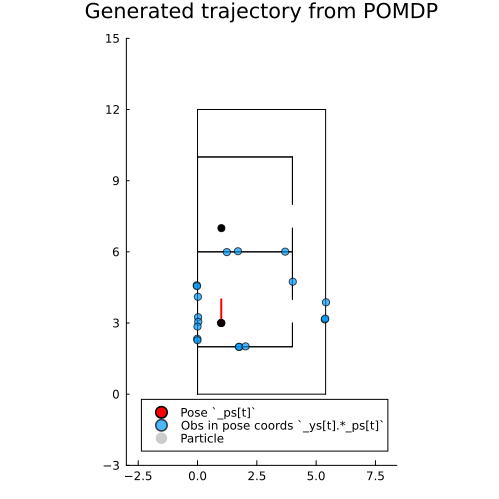

In [243]:
using Random
let tr = tr[], states = pf_observable[]

    poses = [
        L.Pose(position, PARAMS.orientation)
        for position in GenPOMDPs.state_sequence(tr)
    ];
    ptclouds = [
        obss[:obs].*pose
        for (obss, pose) in zip(
            GenPOMDPs.observation_sequence(tr),
            poses
        )
    ];

    # -----------------------
    col = palette(:default)
    ani = Animation()
    # states = [state]
    for t=0:0
        p = poses[t + 1]
        y = ptclouds[t + 1]
    
        agent_plt = plot(
            size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
            xlim=(_bb[1][1]-3, _bb[2][1]+3),
            ylim=(_bb[1][2]-3, _bb[2][2]+3),
            legend=:bottomleft,
        )
        plot!(_segs, c=:black, linewidth=1, label=nothing)
        plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([p.x], c=:red, label="Pose `_ps[t]`")
        scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")
    
        particles = states[t + 1]
        labeled=false
        for (w, tr) in zip(
                GenParticleFilters.get_norm_weights(particles),
                GenParticleFilters.get_traces(particles)
            )
            pos = tr[GenPOMDPs.state_addr(t)]
            if !labeled && sqrt(w) > 0.1
                scatter!([pos], c=:black, seriesalpha=sqrt(w), label="Particle")
                labeled=true
            else
                scatter!([pos], c=:black, seriesalpha=sqrt(w), label=nothing)
            end
        end
    
        frame(ani, agent_plt)
    end
    # gif(ani, "smcp3_coarse_to_fine.gif", fps=1) # gif(ani, fname, fps=10)
    gif(ani, fps=1)
end

In [244]:
GOAL = [1., 12.]

2-element Vector{Float64}:
  1.0
 12.0

In [245]:
while Geo.norm(currentpos(tr[]) - GOAL) > .3 && T(tr[]) < 100
    _tr = GPF.sample_unweighted_traces(pf_observable[][end], 1)[1]
    pos = _tr[state_addr(T(_tr), :pos)]
    action = find_action_using_grid(pos, GOAL)[1]
    take_action(action)
end

BoundsError: BoundsError: attempt to access 1-element Vector{Tuple{Int64, Int64}} at index [2]

In [246]:
T(tr[])

55

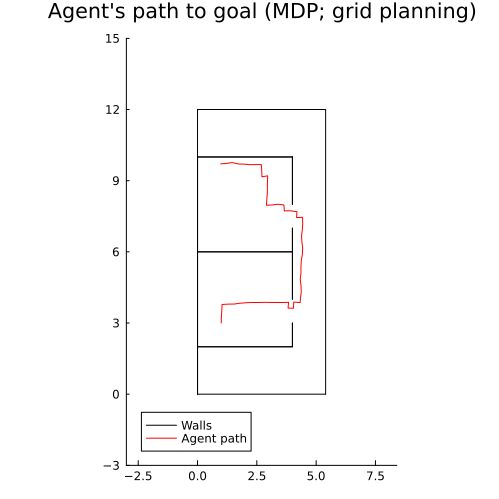

In [247]:
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Agent's path to goal (MDP; grid planning)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, label="Walls")
plot!(GenPOMDPs.state_sequence(tr[]), c=:red, label="Agent path")

Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/pomdp_nav_unambiguous.gif")
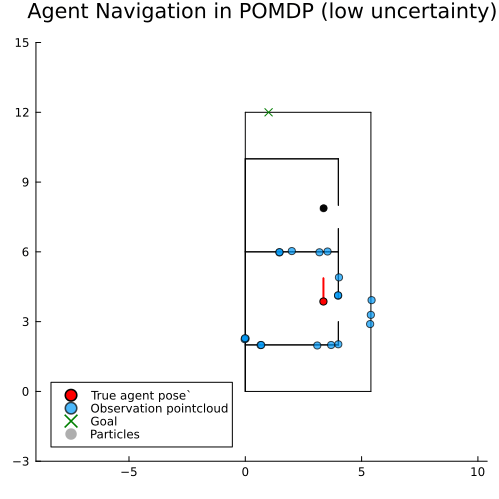

In [250]:
using Random
let tr = tr[], states = pf_observable[]

    poses = [
        L.Pose(position, PARAMS.orientation)
        for position in GenPOMDPs.state_sequence(tr)
    ];
    ptclouds = [
        obss[:obs].*pose
        for (obss, pose) in zip(
            GenPOMDPs.observation_sequence(tr),
            poses
        )
    ];

    # -----------------------
    col = palette(:default)
    ani = Animation()
    # states = [state]
    for t=12:18#length(states)-2
        p = poses[t + 1]
        y = ptclouds[t + 1]
    
        agent_plt = plot(
            size=(500,500), aspect_ratio=:equal, title="Agent Navigation in POMDP (low uncertainty)", grid=false,
            xlim=(_bb[1][1]-9, _bb[2][1]+5),
            ylim=(_bb[1][2]-3, _bb[2][2]+3),
            legend=:bottomleft,
        )
        plot!(_segs, c=:black, linewidth=1, label=nothing)
        plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([p.x], c=:red, label="True agent pose`")
        scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Observation pointcloud")
    
        scatter!([GOAL], c=:green, marker=:x, label="Goal")

        particles = states[t + 1]
        labeled=false
        for (w, tr) in zip(
                GenParticleFilters.get_norm_weights(particles),
                GenParticleFilters.get_traces(particles)
            )
            pos = tr[GenPOMDPs.state_addr(t)]
            if !labeled && sqrt(w) > 0.1
                scatter!([pos], c=:black, seriesalpha=sqrt(w), label="Particles")
                labeled=true
            else
                scatter!([pos], c=:black, seriesalpha=sqrt(w), label=nothing)
            end
        end
    
        frame(ani, agent_plt)
    end
    gif(ani, "pomdp_nav_unambiguous.gif", fps=1) # gif(ani, fname, fps=10)
    # gif(ani, fps=10)
end